In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_json
from df_utils import form_pred_df, form_last_quarter_df, form_portfolio_cumm_df
from data import load_cf1_df
from download import form_quandl_url, multi_ticker_download, get_tinkoff_portfolio, get_tinkoff_price
import pipelines.marketcap

sns.set()
config = load_json("config.json")

In [2]:
my_tickers = ['EXP', 'WOR', 'CMC', 'MAS', 'NEM', 
'USM', 'TDS', 'LUMN',
'MSGS', 'WHR', 'BERY', 'DHI', 'CRI', 'WSM',
'THS', 'K', 'STRA', 'CPB', 'CHD', 'CAG',
'CLR', 'ET', 'HP',
'JEF', 'CACC', 'PGR', 'FCFS', 'MKL', 
'SRPT', 'MRK', 'BLUE', 'UHS', 'MCK',
'KNX', 'AYI', 'NOC', 'MMS', 'FLR',
'KIM', 'PEAK',
'HPE', 'CSOD', 'PINC', 'FICO', 'FB', 'WORK', 'JCOM', 'XRX',
'CMS', 'ETR', 'SWX',

]

In [148]:
set(my_tickers_old).difference(set(my_tickers))

{'AVAV', 'F', 'KRG', 'SWI', 'TWOU'}

In [4]:
url.format(ticker='AAPL')

'https://www.quandl.com/api/v3/datatables/SHARADAR/SF1?ticker=AAPL&api_key=ePtzKxTh-x_3ujf79dLa'

In [3]:
url = form_quandl_url('datatables/SHARADAR/SF1?ticker={ticker}', config)
multi_ticker_download(url, my_tickers[:], '{}/cf1/core_fundamental'.format(config['data_path']), skip_exists=False)

url = form_quandl_url('datatables/SHARADAR/DAILY?ticker={ticker}', config)
multi_ticker_download(url, my_tickers[:], '{}/cf1/daily'.format(config['data_path']), skip_exists=False)

100%|██████████| 51/51 [00:00<00:00, 117791.58it/s]


In [12]:
tickers_df = pd.read_csv('{}/cf1/tickers.csv'.format(config['data_path']))
tickers_df = tickers_df[tickers_df['currency']=='USD']
tickers_df = tickers_df[tickers_df['scalemarketcap'].apply(lambda x: x in ['4 - Mid', '5 - Large', '6 - Mega'])]
ticker_list = tickers_df['ticker'].unique().tolist()

In [4]:
pipeline_path = 'models_data/marketcap_pipeline_16.02.21_15:11'
mc_pipeline = pipelines.marketcap.load(pipeline_path)
mc_df = mc_pipeline.execute(config, my_tickers)

51it [00:00, 62.16it/s]


In [8]:
mc_df

,ticker,date,y
0,EXP,2021-01-28,6.255428e+09
1,EXP,2020-10-30,5.979420e+09
2,EXP,2020-07-30,4.456158e+09
3,EXP,2020-05-22,3.819420e+09
4,EXP,2020-02-04,3.471648e+09
...,...,...,...
501,SWX,2019-08-07,4.809692e+09
502,SWX,2019-05-08,5.191657e+09
503,SWX,2019-02-28,4.256262e+09
504,SWX,2018-11-07,4.171101e+09


In [28]:
tickers_df[tickers_df['ticker'] == 'OZON']

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
15190,SF1,632662,OZON,Ozon Holdings PLC,NASDAQ,N,ADR Common Stock,69269L104,5961.0,Retail Trade,...,RUB,Cyprus,2020-11-25,2020-11-25,2020-11-25,2020-12-31,2018-12-31,2020-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.ozon.ru


In [5]:
with open('models_data/marketcap_model.pickle', 'rb') as f:
    marketcap_model = pickle.load(f)

with open('models_data/feat_calculator.pickle', 'rb') as f:
    feat_calculator = pickle.load(f) 

In [6]:
X = feat_calculator.calc_feats(ticker_list)

100%|██████████| 3874/3874 [00:00<00:00, 825730.95it/s]


In [7]:
pred = marketcap_model.predict(X.drop(['ticker', 'marketcap', 'date'], axis=1), X['ticker'])
pred = np.exp(pred)

In [8]:
pred_df = form_pred_df(X, pred, tickers_df)
last_quarter_df = form_last_quarter_df(pred_df)

100%|██████████| 2416/2416 [00:04<00:00, 506.08it/s]


In [9]:
portfolio_df = pd.DataFrame()
portfolio_df['ticker'] = my_tickers
portfolio_df = pd.merge(portfolio_df, last_quarter_df, on='ticker', how='left')


grouped_sectors = last_quarter_df.groupby('sector')['marketcap'].sum().reset_index()
grouped_sectors['sector_part'] = grouped_sectors['marketcap'] / grouped_sectors['marketcap'].sum()
del grouped_sectors['marketcap']

portfolio_df = pd.merge(portfolio_df, grouped_sectors, on='sector', how='left')
tmp = portfolio_df.groupby('sector')['ratio_ratio'].sum().reset_index().rename({'ratio_ratio':'ratio_ratio_sum'}, axis=1)
portfolio_df = pd.merge(portfolio_df, tmp, on='sector', how='left')
portfolio_df['part'] = portfolio_df['ratio_ratio'] / portfolio_df['ratio_ratio_sum'] * portfolio_df['sector_part'] * 52_000
del portfolio_df['ratio_ratio_sum']
del portfolio_df['sector_part']

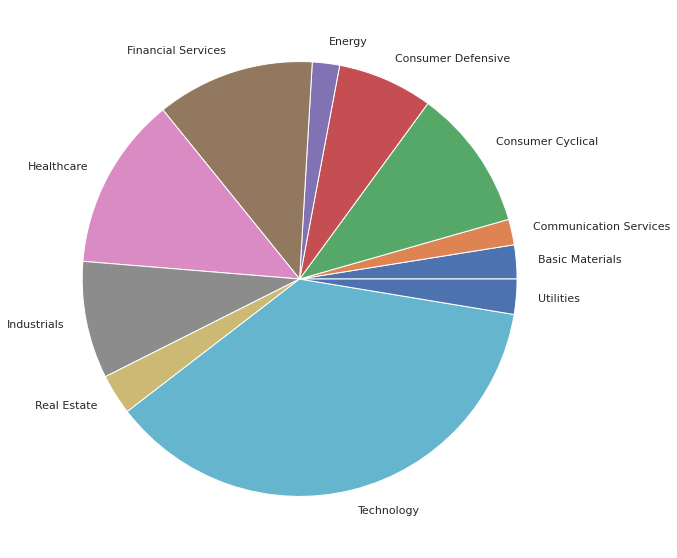

In [103]:
plt.figure(figsize=(25,10))
plt.pie(grouped_sectors['sector_part'], labels=grouped_sectors['sector'])
plt.show()

In [16]:
tinkoff_portfolio_df = pd.DataFrame(get_tinkoff_portfolio(config))[['ticker', 'balance']]

In [17]:
portfolio_df = pd.merge(portfolio_df, tinkoff_portfolio_df, on='ticker', how='left')

In [19]:
portfolio_df['price'] = [get_tinkoff_price(ticker, config) for ticker in portfolio_df['ticker'].values]

In [20]:
portfolio_df['share_cnt'] = (portfolio_df['part'] / portfolio_df['price']).apply(lambda x: round(x))

In [10]:
portfolio_df.sort_values('ratio_ratio')

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio,part
39,PEAK,2021-02-10,1.650535e+10,7.071445e+09,Real Estate,NYSE,Real Estate Investment Trusts,0.428434,1.680700e+10,0.420744,0.588642,0.714771,655.142286
38,KIM,2020-11-05,4.580161e+09,1.068101e+10,Real Estate,NYSE,Real Estate Investment Trusts,2.332016,7.763400e+09,1.375816,1.374983,1.000606,917.132158
22,HP,2021-02-09,2.796669e+09,2.297899e+09,Energy,NYSE,Drilling Oil & Gas Wells,0.821656,2.913200e+09,0.788789,0.786398,1.003040,318.857446
42,PINC,2021-02-02,4.337030e+09,5.223472e+09,Technology,NASDAQ,Services-Management Services,1.204389,4.280800e+09,1.220209,1.209614,1.008759,2082.636849
11,DHI,2021-01-27,2.715397e+10,3.064947e+10,Consumer Cyclical,NYSE,Operative Builders,1.128729,3.035090e+10,1.009837,0.993594,1.016348,761.180996
35,NOC,2021-01-28,4.885349e+10,5.881305e+10,Industrials,NYSE,Search Detection Navagation Guidance Aeronauti...,1.203866,4.995380e+10,1.177349,1.152280,1.021756,809.671800
1,WOR,2021-01-11,2.889855e+09,3.973796e+09,Basic Materials,NYSE,Steel Works Blast Furnaces & Rolling & Finishi...,1.375085,3.097100e+09,1.283070,1.233152,1.040480,210.308104
36,MMS,2021-02-04,4.965978e+09,6.609201e+09,Industrials,NYSE,Services-Business Services Nec,1.330896,5.162600e+09,1.280208,1.228343,1.042223,825.890804
46,JCOM,2020-11-09,3.583080e+09,7.169555e+09,Technology,NASDAQ,Telegraph & Other Message Communications,2.000948,4.903400e+09,1.462160,1.395183,1.048006,2163.663373
47,XRX,2020-11-04,3.620525e+09,1.119107e+10,Technology,NYSE,Computer Peripheral Equipment Nec,3.091008,4.677900e+09,2.392328,2.226822,1.074324,2217.998441


In [130]:
last_quarter_df[last_quarter_df['sector']=='Technology'][:30]

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio
27,WETG,2020-12-15,2.431394e+09,3.085475e+09,Technology,OTC,Services-Computer Processing & Data Preparation,1.269015,1.710500e+09,1.803844,1.066219,1.691815
34,FB,2021-01-28,7.546325e+11,1.211765e+12,Technology,NASDAQ,Services-Computer Programming Data Processing ...,1.605768,7.634603e+11,1.587201,1.053813,1.506151
57,CTSH,2020-10-29,3.801298e+10,5.021984e+10,Technology,NASDAQ,Services-Computer Programming Services,1.321124,3.983080e+10,1.260829,0.927666,1.359141
58,DELL,2020-12-07,5.277123e+10,4.054114e+10,Technology,NYSE,Electronic Computers,0.768243,5.969190e+10,0.679173,0.501444,1.354436
63,HPE,2020-12-10,1.567722e+10,4.924414e+10,Technology,NYSE,Wholesale-Computers & Peripheral Equipment & S...,3.141127,1.699660e+10,2.897293,2.169135,1.335691
66,LITE,2021-02-02,6.672198e+09,9.723051e+09,Technology,NASDAQ,Communications Equipment Nec,1.457249,6.720600e+09,1.446753,1.089473,1.327939
76,SNX,2021-01-28,4.364061e+09,7.348916e+09,Technology,NYSE,Wholesale-Computers & Peripheral Equipment & S...,1.683963,4.521400e+09,1.625363,1.245128,1.305378
79,CACI,2021-01-28,6.222031e+09,8.208320e+09,Technology,NYSE,Services-Computer Integrated Systems Design,1.319235,5.993400e+09,1.369560,1.055849,1.297117
84,SFUN,2020-11-16,9.180420e+07,3.103760e+09,Technology,NYSE,Services-Computer Processing & Data Preparation,33.808472,1.204000e+08,25.778735,20.077372,1.283970
107,SSNC,2020-11-04,1.616417e+10,1.785209e+10,Technology,NASDAQ,Services-Prepackaged Software,1.104424,1.776140e+10,1.005106,0.815679,1.232232


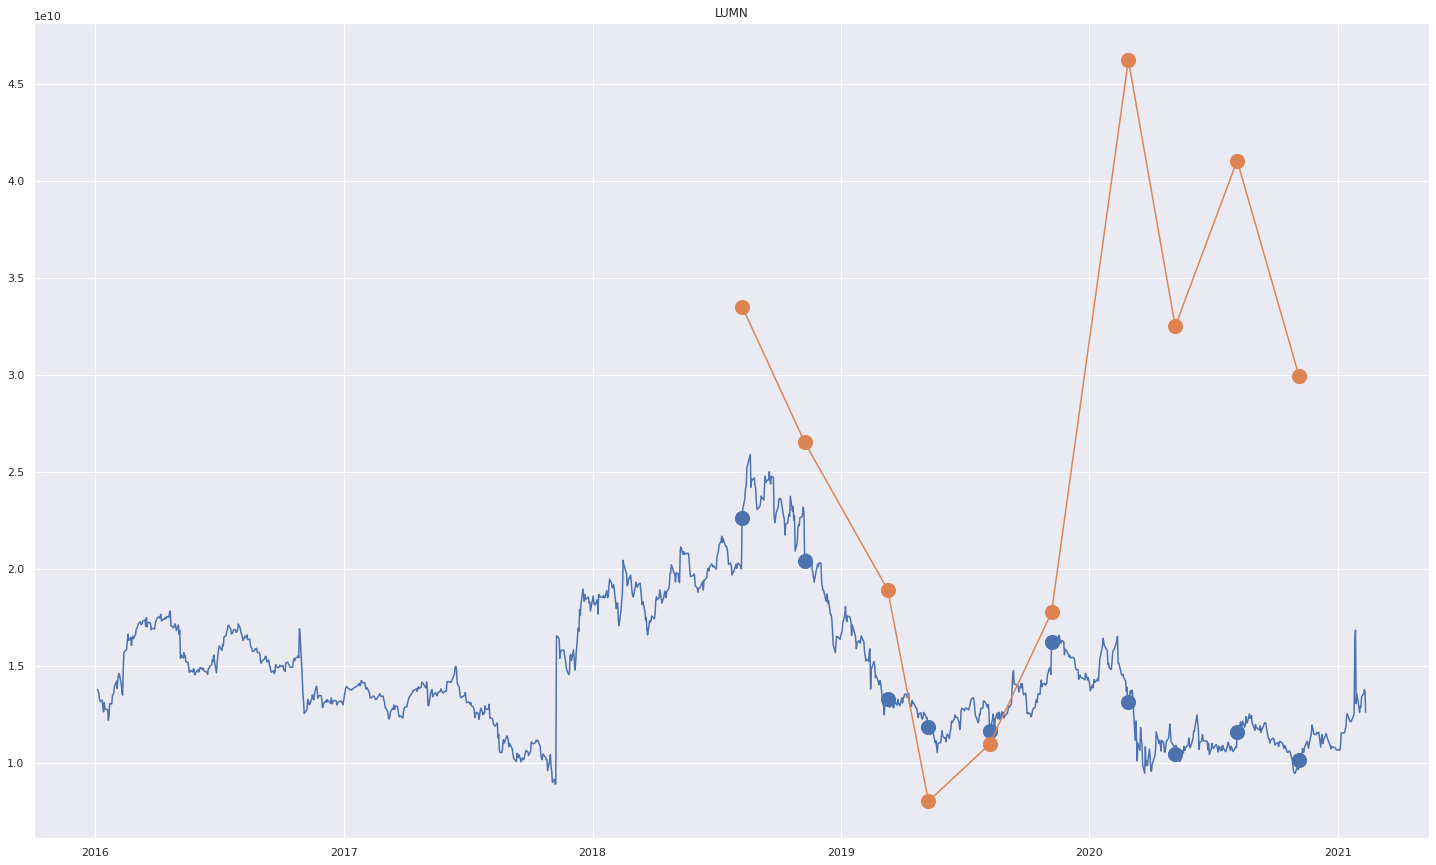

In [15]:
ticker = 'LUMN'

daily_df = load_cf1_df('{}/cf1/daily/{}.json'.format(config['data_path'], ticker))
X_curr = X[X['ticker']==ticker]
pred_curr = pred_df[pred_df['ticker']==ticker]


plt.figure(figsize=(25,15))
plt.title(ticker)
plt.plot([np.datetime64(x) for x in daily_df['date']][::-1], daily_df['marketcap'].values[::-1] * 1e6)
plt.scatter([np.datetime64(x) for x in X_curr['date']][::-1], X_curr['marketcap'].values[::-1], s=200)
plt.scatter([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1], s=200)
plt.plot([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1])
plt.show()

In [13]:
last_quarter_df[last_quarter_df['ticker']=='THS']

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio
137,THS,2021-02-11,2.754358e+09,3.503462e+09,Consumer Defensive,NYSE,Canned Frozen & Preservd Fruit Veg & Food Spec...,1.27197,2.754400e+09,1.271951,1.07629,1.181792


In [120]:
last_quarter_df[last_quarter_df['sicindustry']=='Hotels & Motels'].sort_values('last_ratio', ascending=False)

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio
1257,XHR,2020-10-30,9.371411e+08,2.096751e+09,Real Estate,NYSE,Hotels & Motels,2.237391,1.766200e+09,1.187154,1.690446,0.702273
541,SHO,2020-11-06,1.716459e+09,2.729960e+09,Real Estate,NYSE,Hotels & Motels,1.590461,2.400000e+09,1.137483,1.203617,0.945055
507,STAY,2020-11-09,2.416600e+09,2.853143e+09,Consumer Cyclical,NASDAQ,Hotels & Motels,1.180643,2.668700e+09,1.069113,1.111630,0.961753
1147,MGM,2020-11-03,1.035790e+10,1.667325e+10,Consumer Cyclical,NYSE,Hotels & Motels,1.609713,1.691740e+10,0.985568,1.331851,0.739999
1545,RRR,2020-11-06,2.467462e+09,2.943199e+09,Consumer Cyclical,NASDAQ,Hotels & Motels,1.192804,3.150800e+09,0.934112,1.585421,0.589188
1745,WYND,2020-10-28,2.883223e+09,3.891013e+09,Consumer Cyclical,NYSE,Hotels & Motels,1.349536,4.353200e+09,0.893828,1.937617,0.461303
1756,BYD,2020-11-05,3.752209e+09,4.090355e+09,Consumer Cyclical,NYSE,Hotels & Motels,1.090119,5.918300e+09,0.691137,1.520934,0.454416
770,WH,2020-10-29,4.363012e+09,3.833218e+09,Consumer Cyclical,NYSE,Hotels & Motels,0.878572,5.773600e+09,0.663922,0.768023,0.864456
1573,PK,2020-11-06,2.426812e+09,2.813196e+09,Real Estate,NYSE,Hotels & Motels,1.159215,4.276400e+09,0.657842,1.149970,0.572051
923,H,2020-11-05,5.745784e+09,4.780647e+09,Consumer Cyclical,NYSE,Hotels & Motels,0.832027,7.481000e+09,0.639039,0.783131,0.816005


In [40]:
portfolio_df

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio,sector_part,part
0,EXP,2020-10-30,3.588816e+09,6.832681e+09,Basic Materials,NYSE,Cement Hydraulic,1.903882,4.630100e+09,1.475709,1.222185,1.207436,0.025946,180.584759
1,WOR,2021-01-11,2.889855e+09,3.973796e+09,Basic Materials,NYSE,Steel Works Blast Furnaces & Rolling & Finishi...,1.375085,2.822000e+09,1.408149,1.233152,1.141910,0.025946,170.784793
2,CMC,2021-01-11,2.708742e+09,4.794573e+09,Basic Materials,NYSE,Steel Works Blast Furnaces & Rolling Mills (Co...,1.770037,2.514200e+09,1.906997,1.421917,1.341145,0.025946,200.582474
3,MAS,2020-10-28,1.407031e+10,1.850497e+10,Basic Materials,NYSE,Heating Equip Except Elec & Warm Air; & Plumbi...,1.315178,1.446540e+10,1.279257,1.134041,1.128052,0.025946,168.712132
4,NEM,2020-10-29,4.711695e+10,4.378045e+10,Basic Materials,NYSE,Gold And Silver Ores,0.929187,4.939050e+10,0.886414,0.499761,1.773675,0.025946,265.271891
5,USM,2020-11-05,2.586227e+09,6.363519e+09,Communication Services,NYSE,Radiotelephone Communications,2.460542,2.945900e+09,2.160127,1.379324,1.566077,0.019846,316.363884
6,TDS,2020-11-05,2.014408e+09,4.489149e+09,Communication Services,NYSE,Telephone Communications (No Radiotelephone),2.228520,2.351700e+09,1.908895,1.548732,1.232553,0.019846,248.988640
7,LUMN,2020-11-05,1.018138e+10,2.995453e+10,Communication Services,NYSE,Telephone Communications (No Radiotelephone),2.942090,1.600710e+10,1.871328,2.002338,0.934571,0.019846,188.793177
8,MSGS,2020-11-09,3.653618e+09,4.312504e+09,Consumer Cyclical,NYSE,Services-Miscellaneous Amusement & Recreation,1.180338,4.170300e+09,1.034099,0.670724,1.541766,0.106252,829.260218
9,WHR,2020-10-22,1.231110e+10,2.058114e+10,Consumer Cyclical,NYSE,Household Appliances,1.671755,1.291090e+10,1.594090,1.310714,1.216200,0.106252,654.150127


In [13]:
index_df = form_portfolio_cumm_df(portfolio_df)

In [27]:
snp500_df = pd.read_csv('../Downloads/^GSPC.csv')
snp500_df = snp500_df[['Date', 'Close']].rename({'Date':'date', 'Close':'snp500'}, axis=1)
snp500_df['date'] = snp500_df['date'].apply(lambda x: np.datetime64(x))

In [17]:
index_df

,date,EXP,WOR,CMC,MAS,NEM,USM,TDS,LUMN,MSGS,...,PINC,FICO,SWI,WORK,JCOM,XRX,CMS,ETR,SWX,val
0,2016-01-04,180.584759,170.784793,200.582474,168.712132,265.271891,316.363884,248.988640,188.793177,829.260218,...,1797.478053,1653.947271,0.000000,0.000000,1499.625209,1641.209302,357.548627,351.563177,331.252766,34880.479597
1,2016-01-05,178.520698,172.683497,207.515720,168.044779,264.983696,311.460220,250.076605,187.890673,831.674178,...,1822.507622,1670.704647,0.000000,0.000000,1486.036223,1638.030037,360.359788,353.459822,336.419666,34965.793424
2,2016-01-06,169.341213,172.629760,210.025377,166.163567,266.998337,306.314279,244.316789,185.861066,840.230808,...,1821.975078,1670.704647,0.000000,0.000000,1484.347196,1617.317594,360.862039,351.203964,341.963047,34406.128921
3,2016-01-07,164.542712,164.282630,202.356980,158.577392,271.315813,304.356690,236.061052,182.101773,831.781945,...,1740.850873,1625.522644,0.000000,0.000000,1433.484466,1572.697703,363.069776,346.229583,344.416675,33436.866047
4,2016-01-08,161.808272,163.189979,198.605168,154.935811,259.086591,305.742508,237.149017,180.221442,828.117897,...,1744.401167,1581.084142,0.000000,0.000000,1425.308043,1528.077812,362.469965,346.129003,346.636625,33005.581202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,2021-01-20,282.993941,259.423794,322.478313,275.773515,1387.391373,283.317450,217.931343,166.179903,921.960626,...,1544.093612,8371.710421,1589.569669,2066.631701,1722.653480,657.258077,607.319213,545.026665,427.138992,62312.044854
1271,2021-01-21,280.288904,252.509647,320.044706,273.838193,1360.961790,278.481623,212.701796,166.630470,912.714293,...,1506.815531,8176.512729,1617.980814,2056.451415,1703.229676,666.622745,601.216319,538.986140,421.868235,61800.515401
1272,2021-01-22,280.906358,258.913293,327.510303,271.479011,1348.732568,282.067306,214.585164,167.832896,906.011241,...,1515.939785,8257.096833,1616.978829,2067.607663,1705.149024,657.887634,604.320159,540.713236,429.709459,61948.318082
1273,2021-01-25,279.477393,253.862026,323.099390,271.951569,1346.329137,281.563372,210.196733,171.137512,898.683146,...,1493.821457,8505.369080,1627.127975,2066.152134,1717.586401,647.893408,615.803283,545.199087,443.924923,62422.863395


In [29]:
index_df = pd.merge(index_df, snp500_df, on='date', how='left')

In [32]:
index_df['val'] = index_df['val'] / index_df['val'].values[0]
index_df['snp500'] = index_df['snp500'] / index_df['snp500'].values[0]

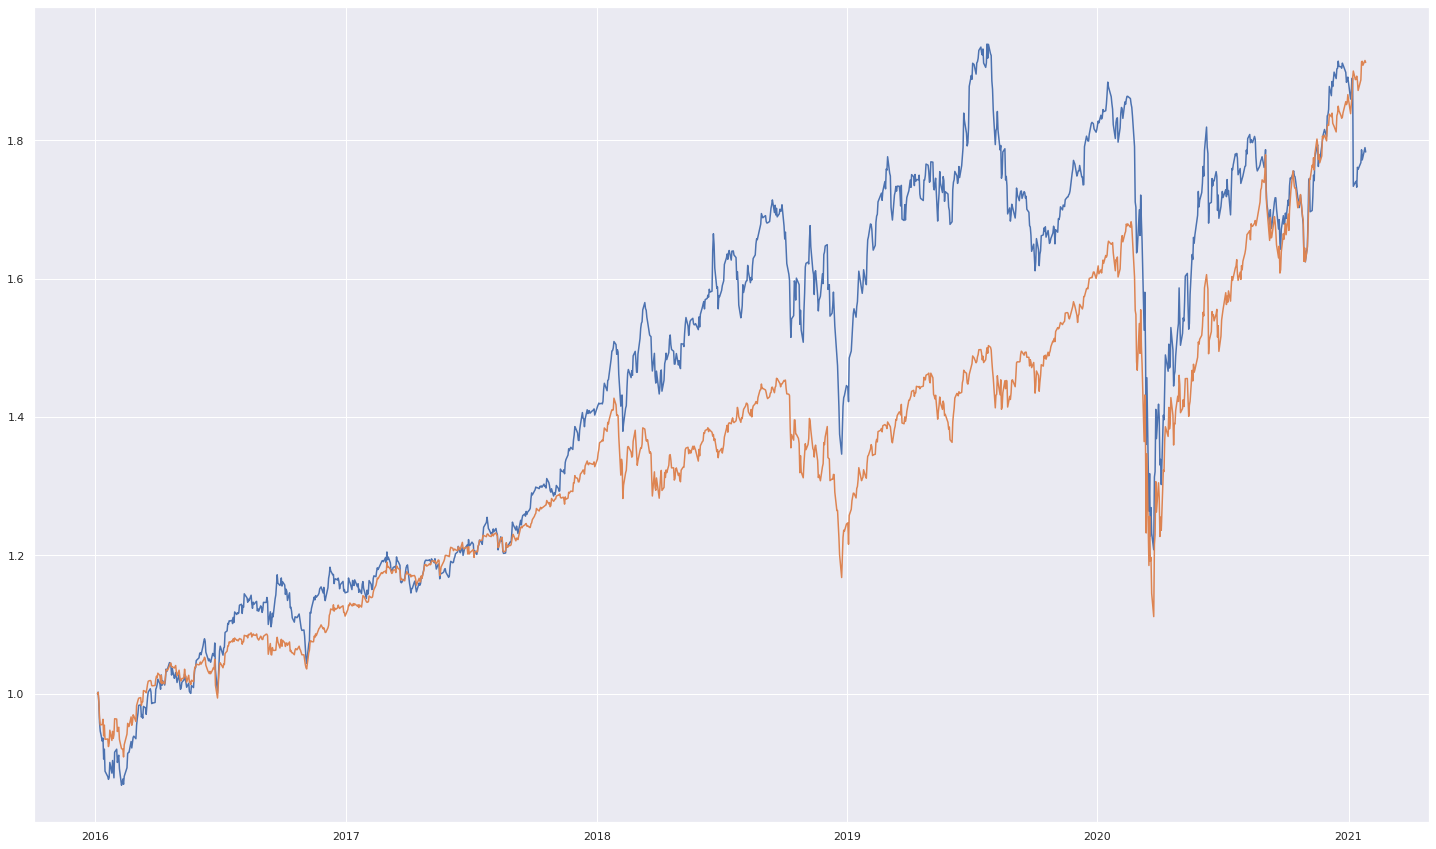

In [34]:
plt.figure(figsize=(25,15))
plt.plot(index_df['date'], index_df['val'])
plt.plot(index_df['date'], index_df['snp500'])
plt.show()

In [37]:
index_df[['val', 'snp500']].corr()

,val,snp500
val,1.000000,0.919829
snp500,0.919829,1.000000


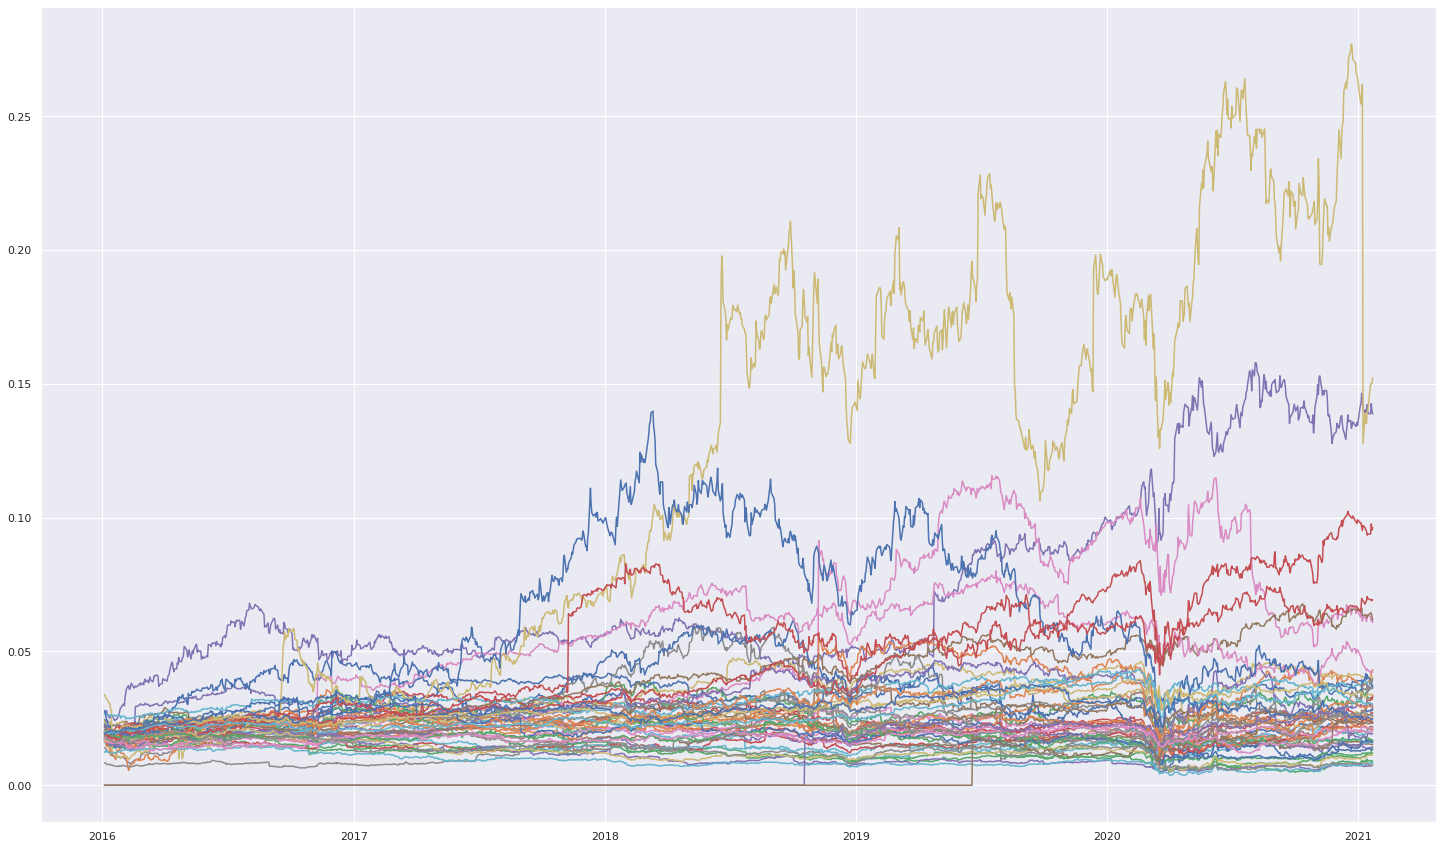

In [102]:
plt.figure(figsize=(25,15))
for ticker in index_df.columns[1:-1]:
    plt.plot(index_df['date'], index_df[ticker])

In [ ]:
/portfolio